In [35]:
import numpy as np
from vivarium import Vivarium
from spatio_flux import PROCESS_DICT, TYPES_DICT, build_path

In [36]:
v = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

In [37]:
v.get_types()

,Type
0,
1,composite
2,length/time
3,enum
4,current^2*time^3/length^2*mass
...,...
97,any
98,mass/length
99,mass/current*time^2
100,kinetics


In [38]:
# view the available processes
v.get_processes()

,Process
0,ram-emitter
1,composite
2,console-emitter
3,DynamicFBA
4,json-emitter
5,DiffusionAdvection
6,Particles
7,MinimalParticle


## dFBA alone

In [39]:
# inspect the config schema for the 'increase' process
v.process_schema('DynamicFBA')

'(model_file:string|kinetic_params:map[tuple[float,float]]|substrate_update_reactions:map[string]|biomass_identifier:string|bounds:map[bounds])'

In [40]:
# TODO - enable get_dataclass to work with the new process
# dfba_config  = v.get_dataclass('DynamicFBA')
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }
}

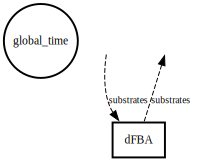

In [41]:
# add a dynamic FBA process called 'dFBA'
v.add_process(name="dFBA",
              process_id="DynamicFBA",
              config=dfba_config,
              )
v.diagram(dpi='70')

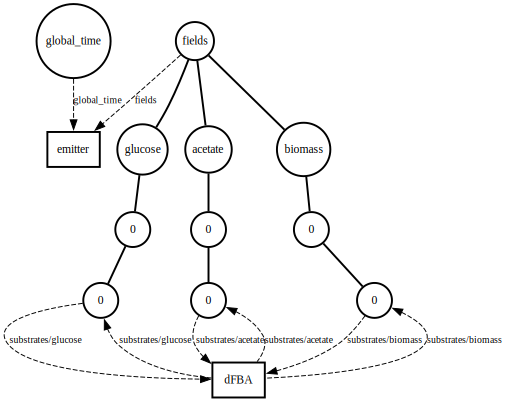

In [42]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
i = 0
j = 0

v.connect_process(
    process_name="dFBA",
    inputs={
            "substrates": {
                mol_id: build_path(mol_id, path, i, j)
                for mol_id in mol_ids}
        },
    outputs={
            "substrates": {
                mol_id: build_path(mol_id, path, i, j)
                for mol_id in mol_ids}
        }
)

# add an emitter to save results
v.add_emitter()

# TODO -- show_values does not work
v.diagram(dpi='70', show_values=True)

In [43]:
v.set_value(path = ['fields', 'glucose', 0, 0], value=10)
v.set_value(path = ['fields', 'biomass', 0, 0], value=0.1)
field = v.get_value(['fields'])
print(field)

{'glucose': {0: {0: 10}}, 'acetate': {0: {0: 0.0}}, 'biomass': {0: {0: 0.1}}}


In [44]:
# run the simulation for 10 time units
v.run(interval=60)

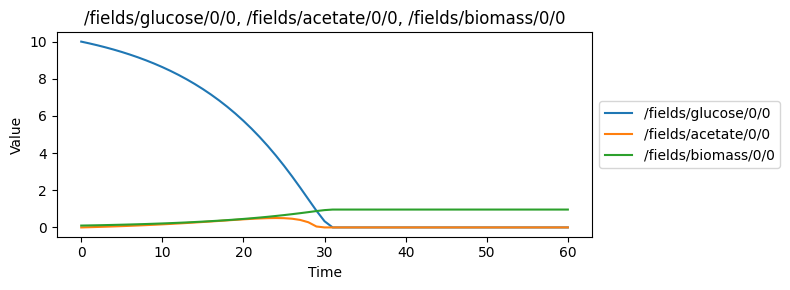

In [45]:
v.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [
            '/fields/glucose/0/0',
            '/fields/acetate/0/0',
            '/fields/biomass/0/0'
        ]
    ]
)

## Spatial Dynamic FBA

In [50]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
rows = 2
columns = 2

# make the vivarium
v2 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=path,
        type='array',
        value=np.random.rand(rows, columns)
    )

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):
        dfba_name = f"dFBA[{i},{j}]"

        # add a process for this location
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            config=dfba_config,
        )
        v2.connect_process(
            process_name=dfba_name,
            inputs={
                    "substrates": {
                        mol_id: build_path(mol_id, path, i, j)
                        for mol_id in mol_ids}
                },
            outputs={
                    "substrates": {
                        mol_id: build_path(mol_id, path, i, j)
                        for mol_id in mol_ids}
                }
        )

v2.diagram(dpi='70')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()